In [1]:
import json
from prettytable import PrettyTable
import json
import os
import random
import pandas as pd

# Read the jsonl file and convert it to a JSON list
def jsonl_to_json_list(jsonl_file_path):
    json_list = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            json_list.append(json_obj)
    
    return json_list

# Save the JSON list to a file
def save_as_json(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(json_list, outfile, indent=4)

def save_as_jsonl(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for json_obj in json_list:
            json.dump(json_obj, outfile)
            outfile.write('\n')

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

def deduplicate_data(data):
    seen = set()
    deduplicated_data = []
    for item in data:
        idx = item['realidx']
        if idx not in seen:
            deduplicated_data.append(item)
            seen.add(idx)
    return deduplicated_data

def calculate_accuracy(data):
    correct_predictions = 0
    total_predictions = len(data)
    for item in data:
        if 'predicted_answer' not in item:
            print(item['realidx'])
        if item['answer_idx'] == item['predicted_answer']:
            correct_predictions += 1
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

def calculate_cost_from_token_usage(data, model):
    total_cost = 0
    for item in data:
        if 'cost' in item:
            total_cost += item['cost']
        elif model == 'gpt-4o-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 0.15 / 1000000 + item['token_usage']['completion_tokens'] * 0.6 / 1000000
        elif model == 'gpt-4o':
            total_cost += item['token_usage']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['completion_tokens'] * 10 / 1000000
        elif model == 'o3-mini' or model == 'o1-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 1.1 / 1000000 + item['token_usage']['completion_tokens'] * 4.4 / 1000000
        elif model == 'claude-3-5-sonnet':
            total_cost += item['token_usage']['prompt_tokens'] * 3.0 / 1000000 + item['token_usage']['completion_tokens'] * 15.0 / 1000000
        elif model == 'claude-3-5-haiku':
            total_cost += item['token_usage']['prompt_tokens'] * 0.8 / 1000000 + item['token_usage']['completion_tokens'] * 4.0 / 1000000
        elif model == 'QwQ-32B-Preview':
            total_cost += item['token_usage']['prompt_tokens'] * 1.2 / 1000000 + item['token_usage']['completion_tokens'] * 1.2 / 1000000
        elif model == 'DeepSeek-R1':
            total_cost += item['token_usage']['prompt_tokens'] * 7 / 1000000 + item['token_usage']['completion_tokens'] * 7 / 1000000
        elif model == 'DeepSeek-V3':
            total_cost += item['token_usage']['prompt_tokens'] * 1.25 / 1000000 + item['token_usage']['completion_tokens'] * 1.25 / 1000000
        elif model == 'Llama-3.3-70B-Instruct-Turbo':
            total_cost += item['token_usage']['prompt_tokens'] * 0.88 / 1000000 + item['token_usage']['completion_tokens'] * 0.88 / 1000000
    return total_cost / len(data)

def calculate_time_from_data(data):
    total_time = 0
    for item in data:
        total_time += item['time_elapsed']
    return total_time / len(data)

Model-Method: gpt-4o-mini+zero_shot -> Overall Accuracy: 13.3% | Avg Cost per Sample: $0.0000 | Avg Time per Sample: 0.8019s
Model-Method: gpt-4o-mini+few_shot -> Overall Accuracy: 21.4% | Avg Cost per Sample: $0.0002 | Avg Time per Sample: 1.1182s
Model-Method: gpt-4o-mini+cot -> Overall Accuracy: 23.2% | Avg Cost per Sample: $0.0003 | Avg Time per Sample: 4.7451s
Model-Method: gpt-4o-mini+cot_sc -> Overall Accuracy: 22.4% | Avg Cost per Sample: $0.0017 | Avg Time per Sample: 23.6218s
Model-Method: gpt-4o-mini+multipersona -> Overall Accuracy: 23.6% | Avg Cost per Sample: $0.0022 | Avg Time per Sample: 34.1868s
Model-Method: gpt-4o-mini+self_refine -> Overall Accuracy: 24.2% | Avg Cost per Sample: $0.0006 | Avg Time per Sample: 9.1830s
Model-Method: gpt-4o-mini+medprompt -> Overall Accuracy: 24.4% | Avg Cost per Sample: $0.0012 | Avg Time per Sample: 14.8653s
Model-Method: gpt-4o-mini+medagents -> Overall Accuracy: 17.2% | Avg Cost per Sample: $0.0060 | Avg Time per Sample: 48.7445s
M

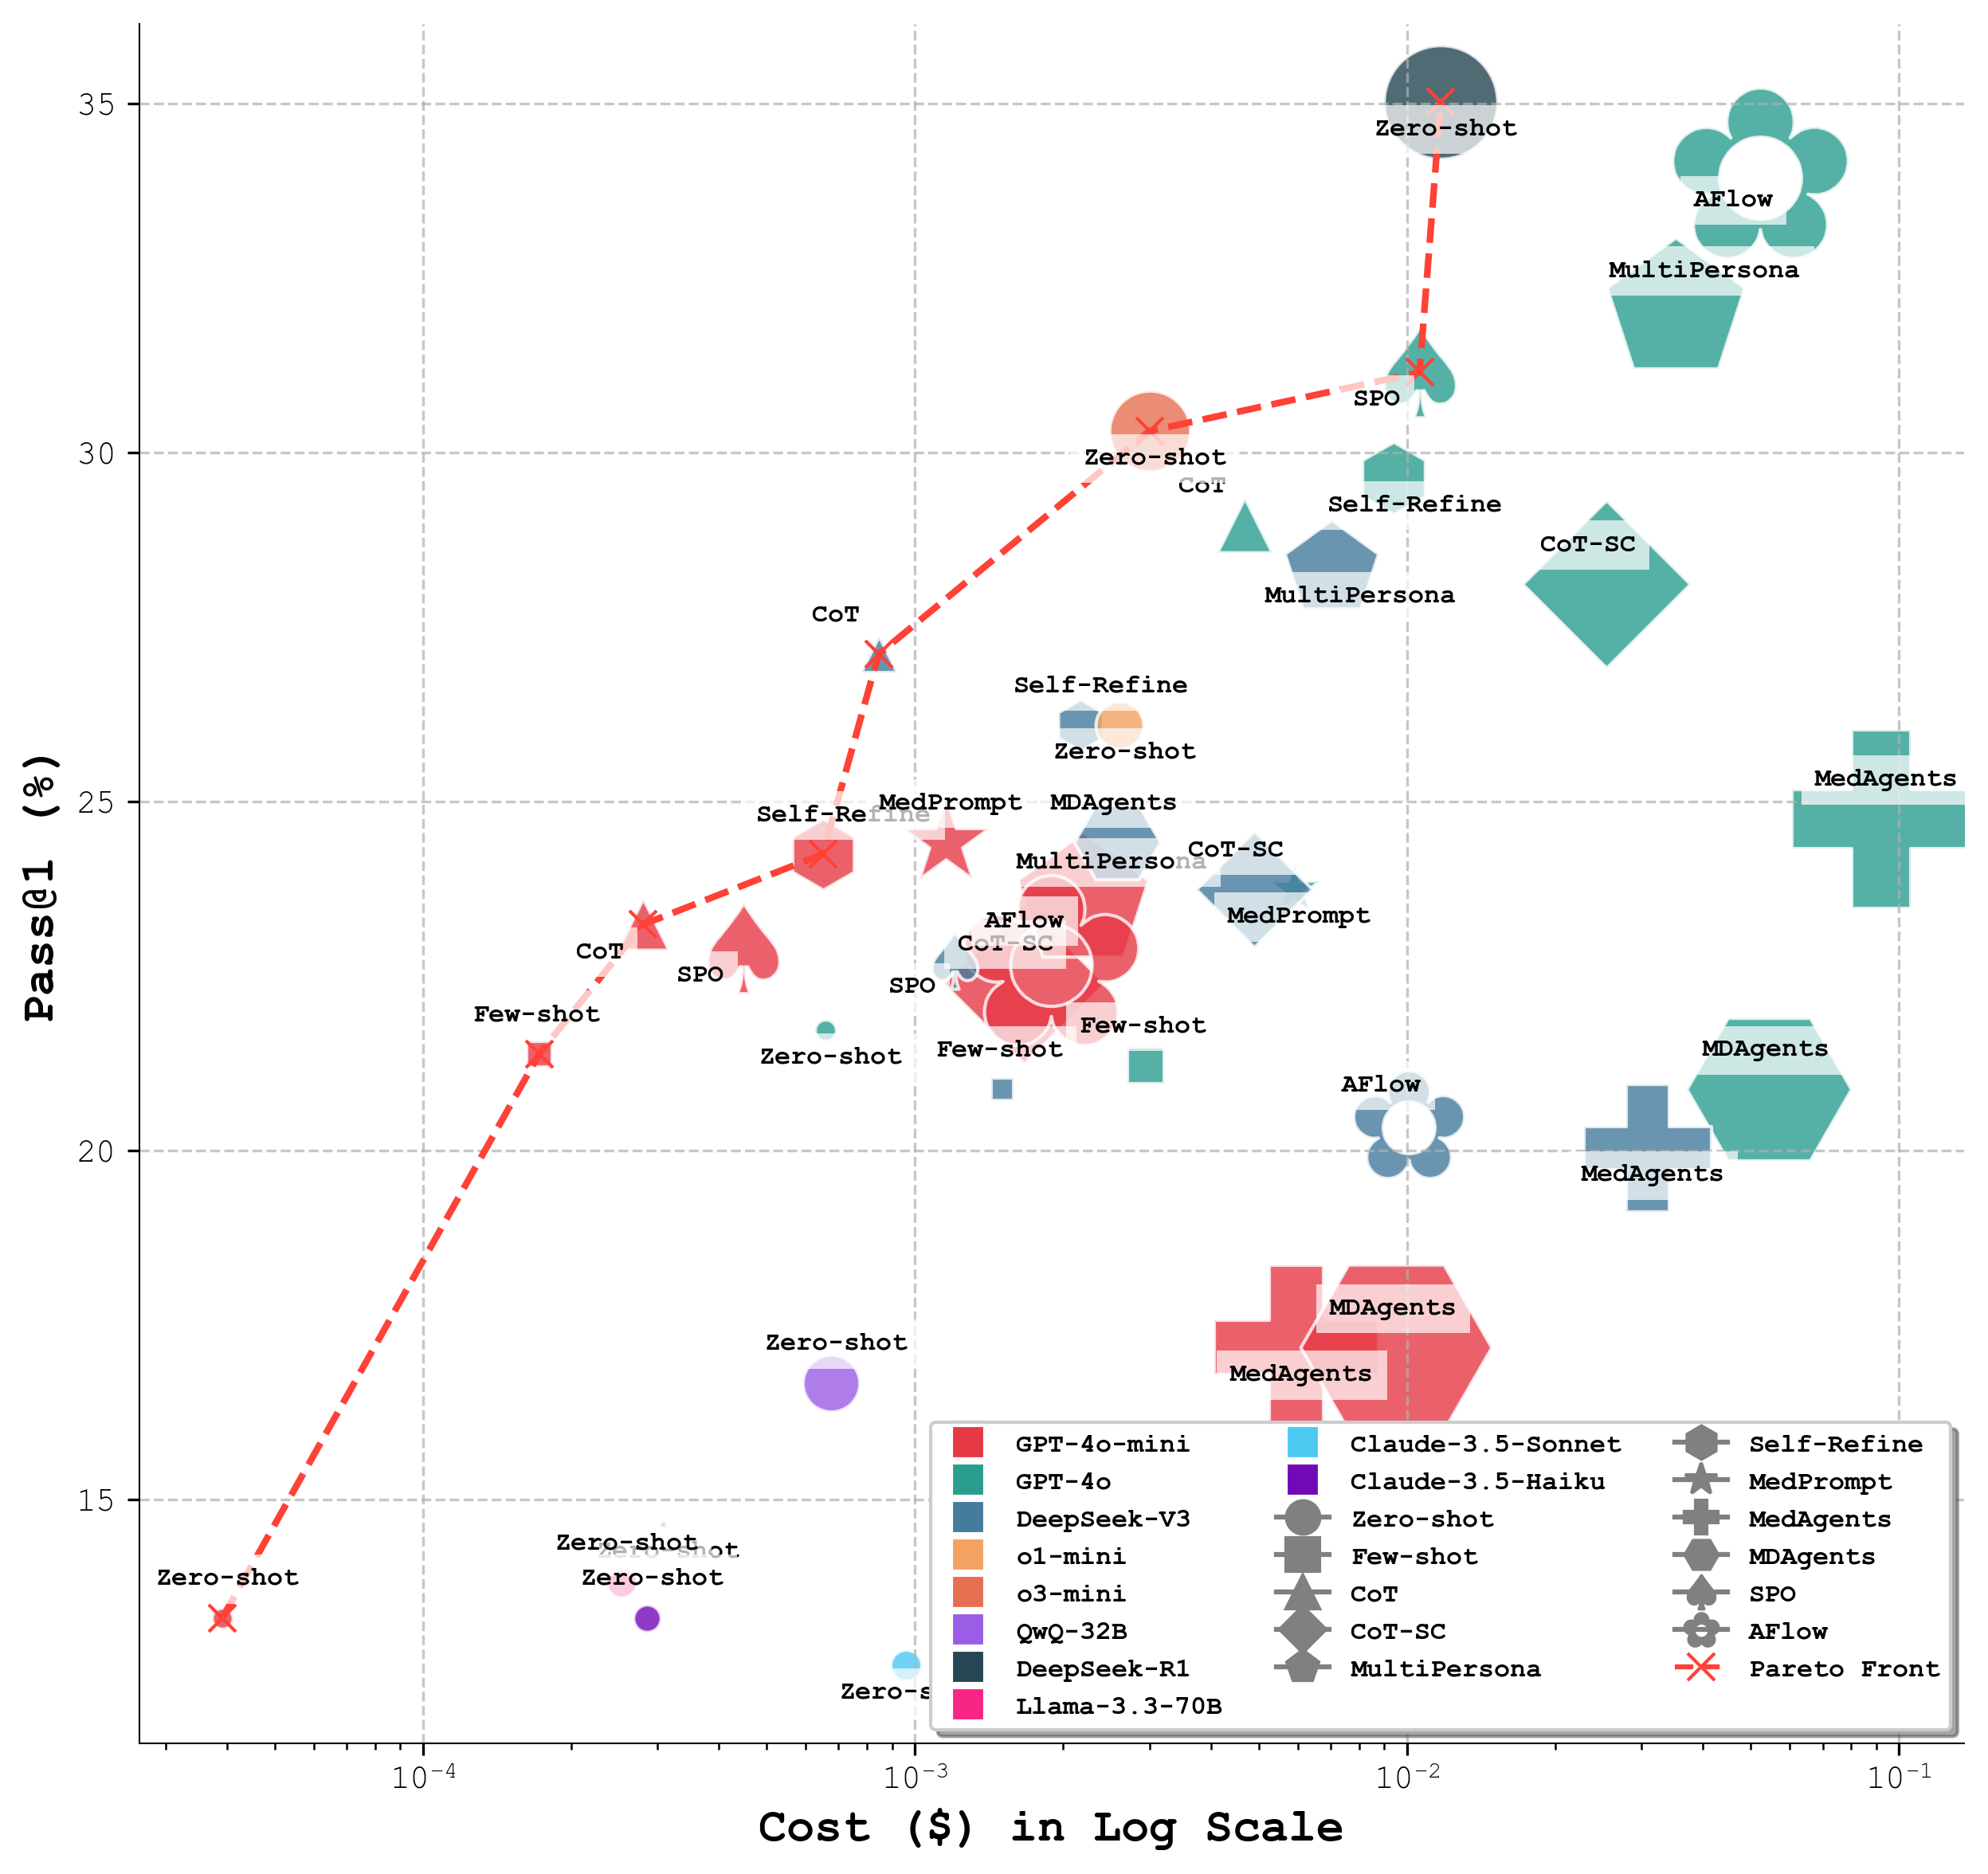

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

# Set different font families for different elements
plt.rcParams['font.family'] = 'Courier New'  # Base font
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Custom font settings
title_font = {'family': 'Courier New', 'size': 16, 'weight': 'bold'}
legend_font = {'family': 'Courier New', 'size': 8, 'weight': 'bold'}
number_font = {'family': 'Courier New', 'size': 10}

tasks = {
    'medqa': ['test_hard'],
    'pubmedqa': ['test_hard'],
    'medmcqa': ['test_hard'],
    'medbullets': ['test_hard'],
    'mmlu': ['test_hard'],
    'mmlu-pro': ['test_hard'],
    'afrimedqa': ['test_hard'],
}
models = [
    'gpt-4o-mini',
    'gpt-4o',
    'DeepSeek-V3',
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
methods = ['zero_shot', 'few_shot', 'cot', 'cot_sc-5', 'multipersona-2', 'self_refine-3', 'medprompt-3', 'medagents', 'mdagents', 'spo', 'aflow']

# Aggregate performance, cost, and time data per model-method combination
model_method_stats = {}

for task in tasks:
    for subtask in tasks[task]:
        for model in models:
            for method in methods:
                model_method = f"{model}+{method.split('-')[0]}"  # Create a combined key
                file_path = f'../output/{task}/{model}-{task}-{subtask}-{method}.json'
                try:
                    data = load_json(file_path)
                    dedup_data = deduplicate_data(data)
                    acc = calculate_accuracy(dedup_data)
                    total_samples = len(dedup_data)
                    cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
                    avg_time = calculate_time_from_data(dedup_data)
                    correct = acc * total_samples

                    if 'DeepSeek-V3' in model_method:
                        avg_time /= 10      # together ai has a slower speed
                    if model_method not in model_method_stats:
                        model_method_stats[model_method] = {
                            'total_correct': 0.0,
                            'total_samples': 0,
                            'total_cost': 0.0,
                            'total_time': 0.0,
                            'base_model': model  # Store the base model for grouping
                        }

                    model_method_stats[model_method]['total_correct'] += correct
                    model_method_stats[model_method]['total_samples'] += total_samples
                    model_method_stats[model_method]['total_cost'] += cost_per_sample * total_samples
                    model_method_stats[model_method]['total_time'] += avg_time * total_samples
                except Exception as e:
                    # print(f"Skipping {file_path}: {e}")
                    pass

# Prepare lists for plotting
model_method_names = []
avg_accuracies = []
avg_costs = []
avg_times = []
base_models = []

for model_method, stats in model_method_stats.items():
    if stats['total_samples'] > 0:
        overall_acc = stats['total_correct'] / stats['total_samples']
        avg_cost = stats['total_cost'] / stats['total_samples']
        overall_time = stats['total_time'] / stats['total_samples']
        
        model_method_names.append(model_method)
        avg_accuracies.append(overall_acc)
        avg_costs.append(avg_cost)
        avg_times.append(overall_time)
        base_models.append(stats['base_model'])
        
        print(f"Model-Method: {model_method} -> Overall Accuracy: {overall_acc*100:.1f}% | "
              f"Avg Cost per Sample: ${avg_cost:.4f} | Avg Time per Sample: {overall_time:.4f}s")

# Compute Pareto frontier
points = list(zip(avg_costs, avg_accuracies))
pareto_indices = []
for i, (cost, acc) in enumerate(points):
    dominated = False
    for j, (other_cost, other_acc) in enumerate(points):
        if i == j:
            continue
        if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
            dominated = True
            break
    if not dominated:
        pareto_indices.append(i)

# Sort Pareto frontier points
pareto_points = sorted([(avg_costs[i], avg_accuracies[i], model_method_names[i]) 
                       for i in pareto_indices], key=lambda x: x[0])
pareto_costs = [pt[0] for pt in pareto_points]
pareto_accs = [pt[1]*100 for pt in pareto_points]

# Plot with distinction between base models and methods
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=300)

# Define color map for base models and marker map for methods
base_model_colors = {
    'gpt-4o-mini': '#E63946',         # Vibrant red
    'gpt-4o': '#2A9D8F',              # Deep teal
    'DeepSeek-V3': '#457B9D',         # Rich blue
    'o1-mini': '#F4A261',             # Sandy orange
    'o3-mini': '#E76F51',             # Burnt orange
    'QwQ-32B-Preview': '#9B5DE5',     # Royal purple
    'DeepSeek-R1': '#264653',         # Dark slate
    'Llama-3.3-70B-Instruct-Turbo': '#F72585',  # Hot pink
    'claude-3-5-sonnet': '#4CC9F0',   # Electric blue
    'claude-3-5-haiku': '#7209B7'     # Deep purple
}

model_map = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'o1-mini': 'o1-mini',
    'o3-mini': 'o3-mini',
    'DeepSeek-V3': 'DeepSeek-V3',
    'DeepSeek-R1': 'DeepSeek-R1',
    'QwQ-32B-Preview': 'QwQ-32B',
    'Llama-3.3-70B-Instruct-Turbo': 'Llama-3.3-70B',
    'claude-3-5-sonnet': 'Claude-3.5-Sonnet',
    'claude-3-5-haiku': 'Claude-3.5-Haiku'
}

method_markers = {
    'zero_shot': 'o',
    'few_shot': 's', 
    'cot': '^',
    'cot_sc': 'D',
    'multipersona': 'p',
    'self_refine': 'h',
    'medprompt': '*',
    'medagents': 'P',
    'mdagents': 'H',
    'spo': '$\u2660$',
    'aflow': '$\u273F$'
}

# Method name mapping
method_names = {
    'zero_shot': 'Zero-shot',
    'few_shot': 'Few-shot',
    'cot': 'CoT',
    'cot_sc': 'CoT-SC',
    'multipersona': 'MultiPersona',
    'self_refine': 'Self-Refine',
    'medprompt': 'MedPrompt',
    'medagents': 'MedAgents',
    'mdagents': 'MDAgents',
    'spo': 'SPO',
    'aflow': 'AFlow'
}

size_scale = 50
max_dist_x = 0.01
max_dist_y = 1.5
    
# Keep track of annotated points to avoid overlap
annotated_points = []

for i, model_method in enumerate(model_method_names):
    base_model = base_models[i]
    method = model_method.split('+', 1)[1]
    
    if method not in method_markers:
        continue
        
    cost = avg_costs[i]
    acc_percent = avg_accuracies[i] * 100
    time_val = avg_times[i]
    marker_size = time_val * size_scale

    color = base_model_colors[base_model]
    marker = method_markers[method]

    plt.scatter(cost, acc_percent, s=marker_size, marker=marker, 
               color=color, alpha=0.8, edgecolors='white', linewidth=1)
    
    should_annotate = True
    for x, y in annotated_points:
        if abs(np.log10(cost) - np.log10(x)) < max_dist_x and abs(acc_percent - y) < max_dist_y:
            should_annotate = False
            break
            
    if should_annotate:
        plt.annotate(method_names[method], (cost, acc_percent),
                    textcoords="offset points", xytext=(-20, 10 * (2 * random.randint(0, 1) - 1)),
                    **legend_font,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        annotated_points.append((cost, acc_percent))

# Overlay Pareto frontier
plt.plot(pareto_costs, pareto_accs, color='#FF4136', 
         linestyle='--', marker='x', markersize=8, linewidth=2, label='Pareto Front')

plt.xlabel("Cost ($) in Log Scale", fontweight='bold')
plt.ylabel("Pass@1 (%)", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis to log scale with custom number font
plt.xscale('log')
ax.tick_params(axis='both', which='major', labelsize=number_font['size'])
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(number_font['family'])

# Create custom legend
legend_elements = []

# Add base model colors to legend
for model, color in base_model_colors.items():
    legend_elements.append(Line2D([0], [0], marker='s', color='w', 
                                label=f'{model_map[model]}', markerfacecolor=color, 
                                markersize=10, markeredgecolor='white'))

# Add method markers to legend
for method, marker in method_markers.items():
    legend_elements.append(Line2D([0], [0], marker=marker, color='gray', 
                                label=method_names[method], markersize=10))

# Add Pareto front to legend
legend_elements.append(Line2D([0], [0], marker='x', color='#FF4136', 
                            label='Pareto Front', markersize=8, linestyle='--'))

# Create legend with custom styling
legend = plt.legend(handles=legend_elements, loc='lower right', 
                   bbox_to_anchor=(1.00, 0.00), frameon=True,
                   fancybox=True, shadow=True, prop=legend_font,
                   ncol=3)  # Display legend in 3 columns

# Add a light background color to the plot
fig.patch.set_facecolor('white')

# Add subtle spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()

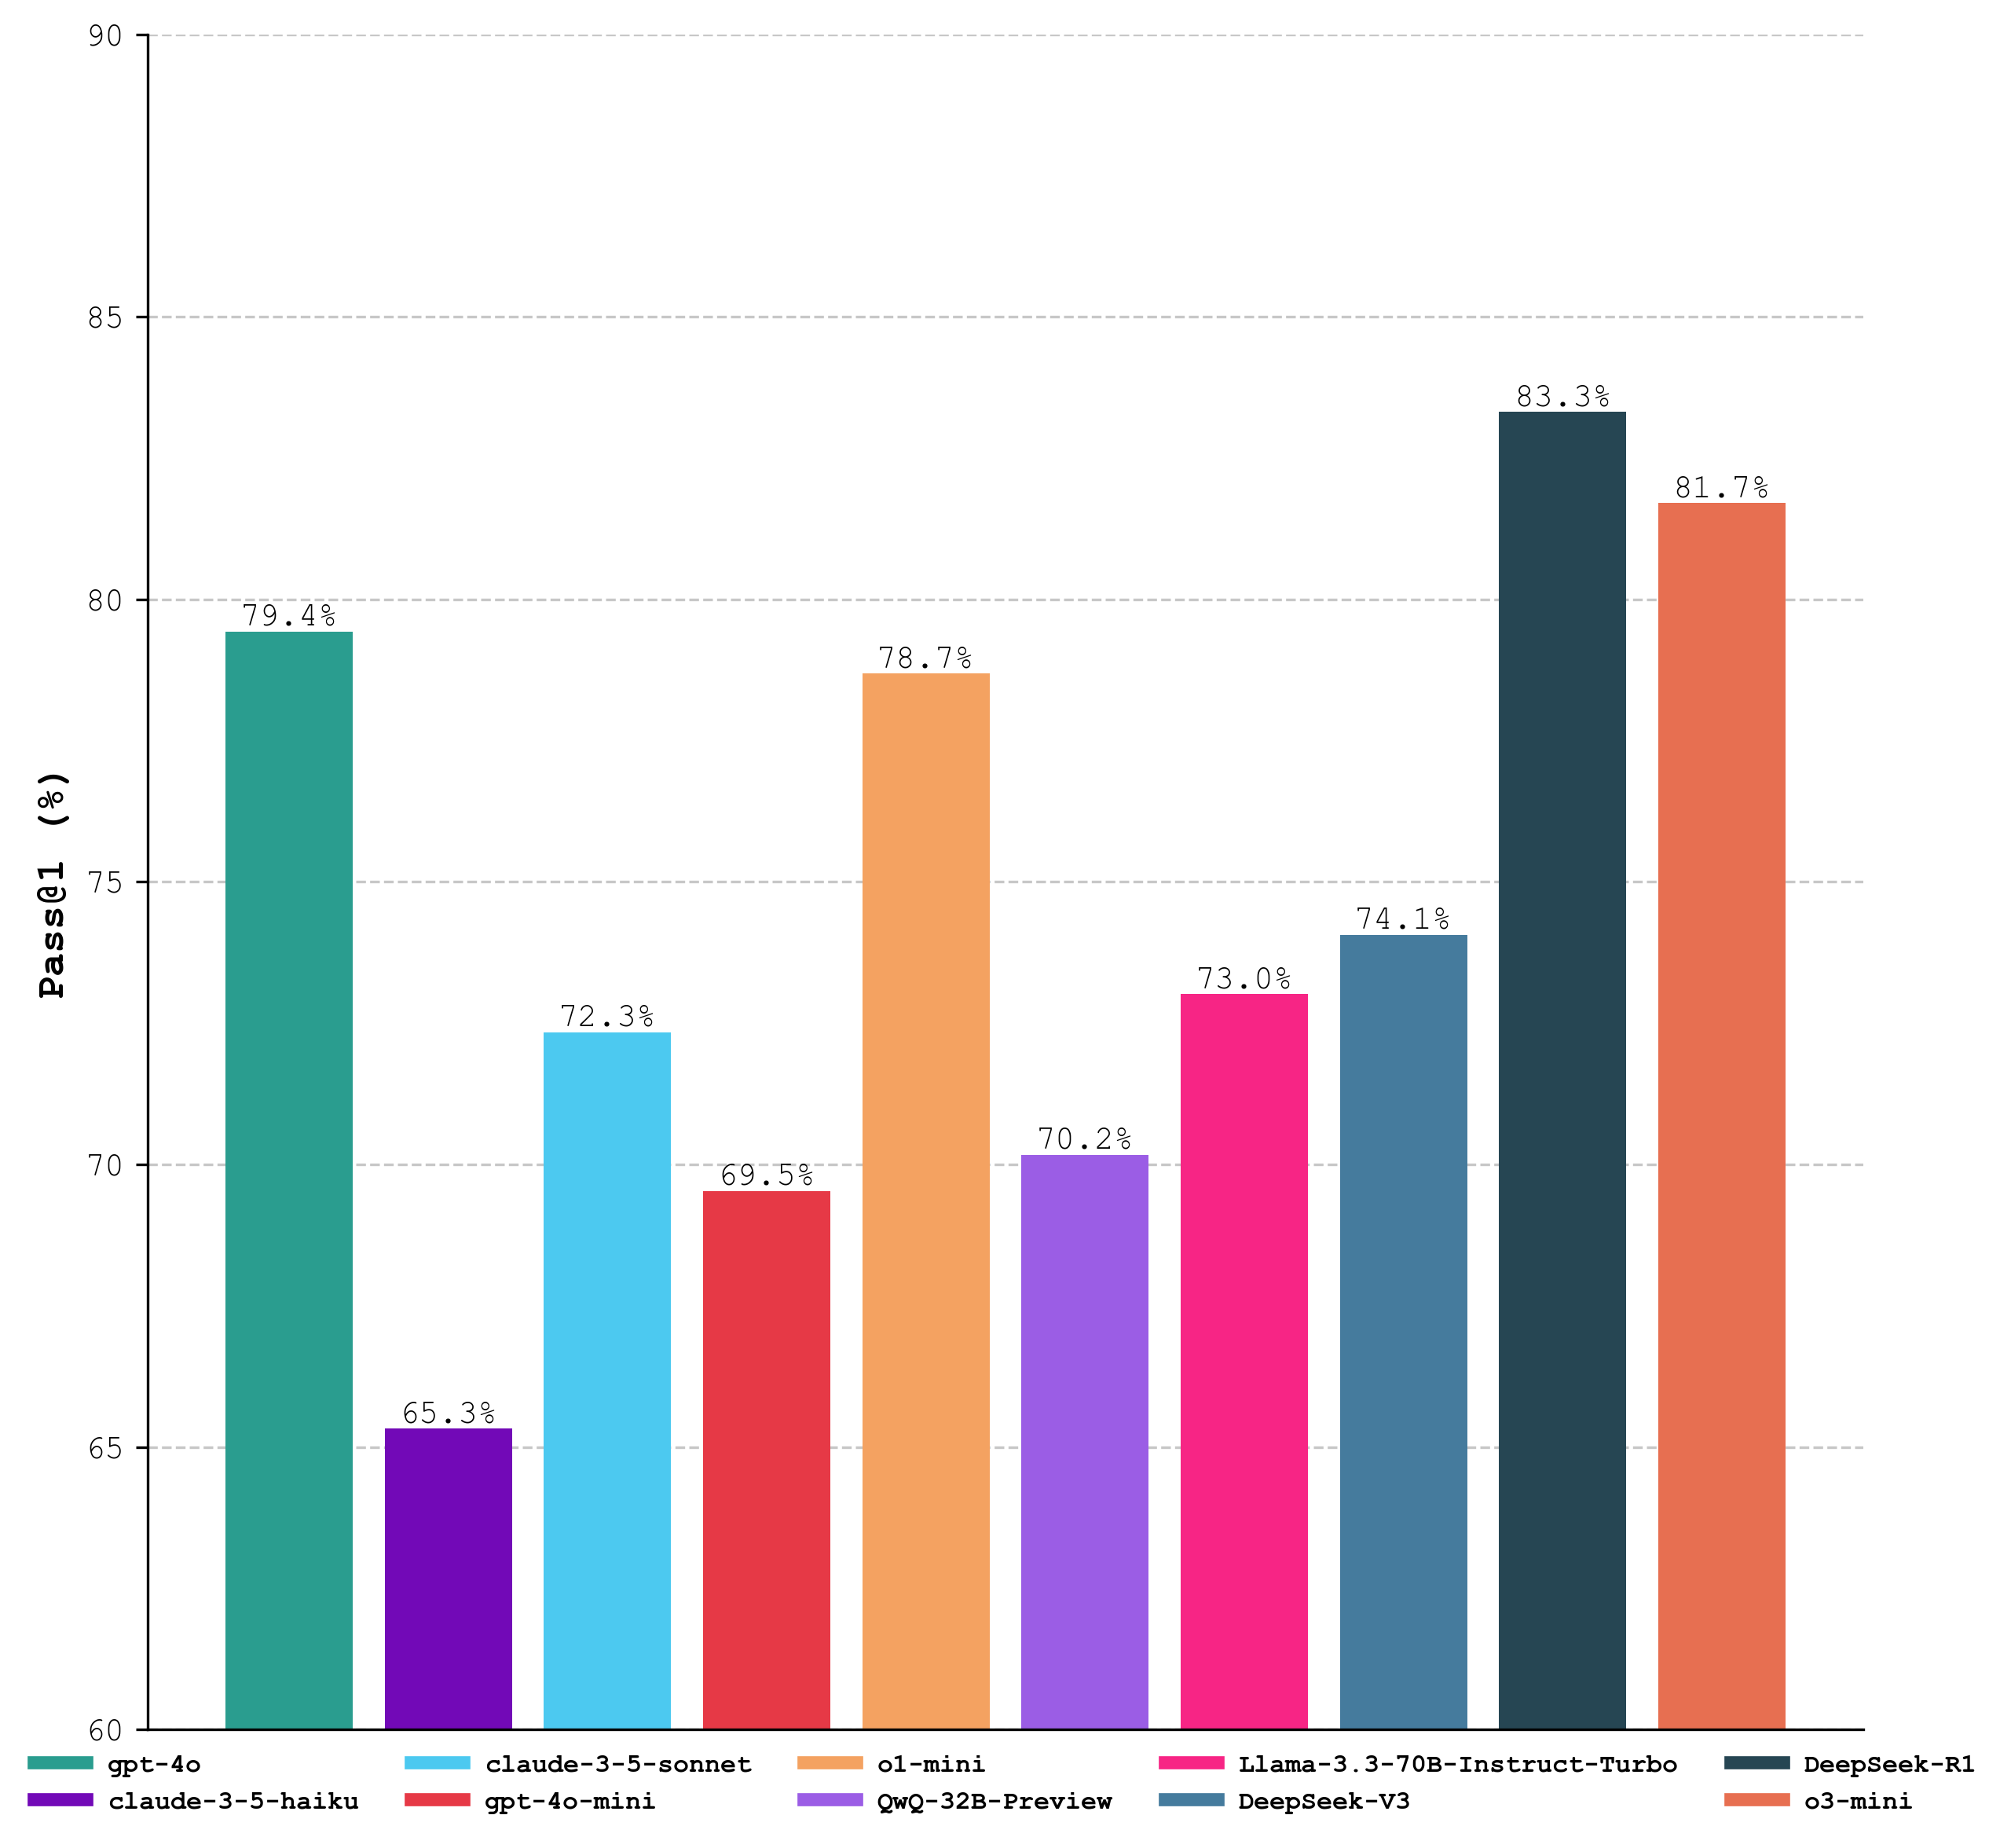

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

# Set style for a clean, modern look
plt.rcParams['font.family'] = 'Courier New'
plt.rcParams['font.size'] = 12

# Custom font settings
title_font = {'family': 'Courier New', 'size': 12, 'weight': 'bold'}
legend_font = {'family': 'Courier New', 'size': 8, 'weight': 'bold'}
number_font = {'family': 'Courier New', 'size': 10}

# Define data
tasks = {
    'medqa': ['test'],
    'pubmedqa': ['test'], 
    'medmcqa': ['test'],
    'medbullets': ['test'],
    'mmlu': ['test'],
    'mmlu-pro': ['test'],
    'afrimedqa': ['test'],
}

models = [
    'gpt-4o',
    'claude-3-5-haiku',
    'claude-3-5-sonnet',
    'gpt-4o-mini',
    'o1-mini',
    'QwQ-32B-Preview',
    'Llama-3.3-70B-Instruct-Turbo',
    'DeepSeek-V3',
    'DeepSeek-R1',
    'o3-mini',
]

methods = ['zero_shot']

# Create figure and axis
fig, ax = plt.subplots(figsize=(9, 8), dpi=300)

# Collect and process data
model_scores = []
for model in models:
    total_correct = 0
    total_samples = 0
    total_acc = 0
    for task in tasks:
        for subtask in tasks[task]:
            for method in methods:
                file_path = f'../output/{task}/{model}-{task}-{subtask}-{method}.json'
                try:
                    data = load_json(file_path)
                    dedup_data = deduplicate_data(data)
                    acc = calculate_accuracy(dedup_data)
                    samples = len(dedup_data)
                    total_acc += acc
                    total_correct += acc * samples
                    total_samples += samples
                except:
                    pass
                    
    if total_samples > 0:
        model_scores.append(total_acc / len(tasks) * 100)
    else:
        model_scores.append(0)

# Define color map for base models and marker map for methods
base_model_colors = {
    'gpt-4o-mini': '#E63946',         # Vibrant red
    'gpt-4o': '#2A9D8F',              # Deep teal
    'DeepSeek-V3': '#457B9D',         # Rich blue
    'o1-mini': '#F4A261',             # Sandy orange
    'o3-mini': '#E76F51',             # Burnt orange
    'QwQ-32B-Preview': '#9B5DE5',     # Royal purple
    'DeepSeek-R1': '#264653',         # Dark slate
    'Llama-3.3-70B-Instruct-Turbo': '#F72585',  # Hot pink
    'claude-3-5-sonnet': '#4CC9F0',   # Electric blue
    'claude-3-5-haiku': '#7209B7'     # Deep purple
}

# Create bars
x = np.arange(len(models))
bars = ax.bar(x, model_scores, color=[base_model_colors[m] for m in models], width=0.8)

# Customize plot
ax.set_ylabel('Pass@1 (%)', fontdict=title_font)
ax.set_ylim([60, 90])
# Remove x-axis labels
plt.xticks([])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontdict=number_font)

# Customize grid
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set background colors
fig.patch.set_facecolor('white')

# Create legend
legend_elements = [Line2D([0], [0], color=base_model_colors[model], lw=4, label=model)
                  for model in models]
ax.legend(handles=legend_elements, 
         loc='upper center', 
         bbox_to_anchor=(0.5, 0),
         ncol=len(models) / 2,
         frameon=False,
         prop=legend_font)

# Adjust layout
plt.tight_layout()
plt.show()

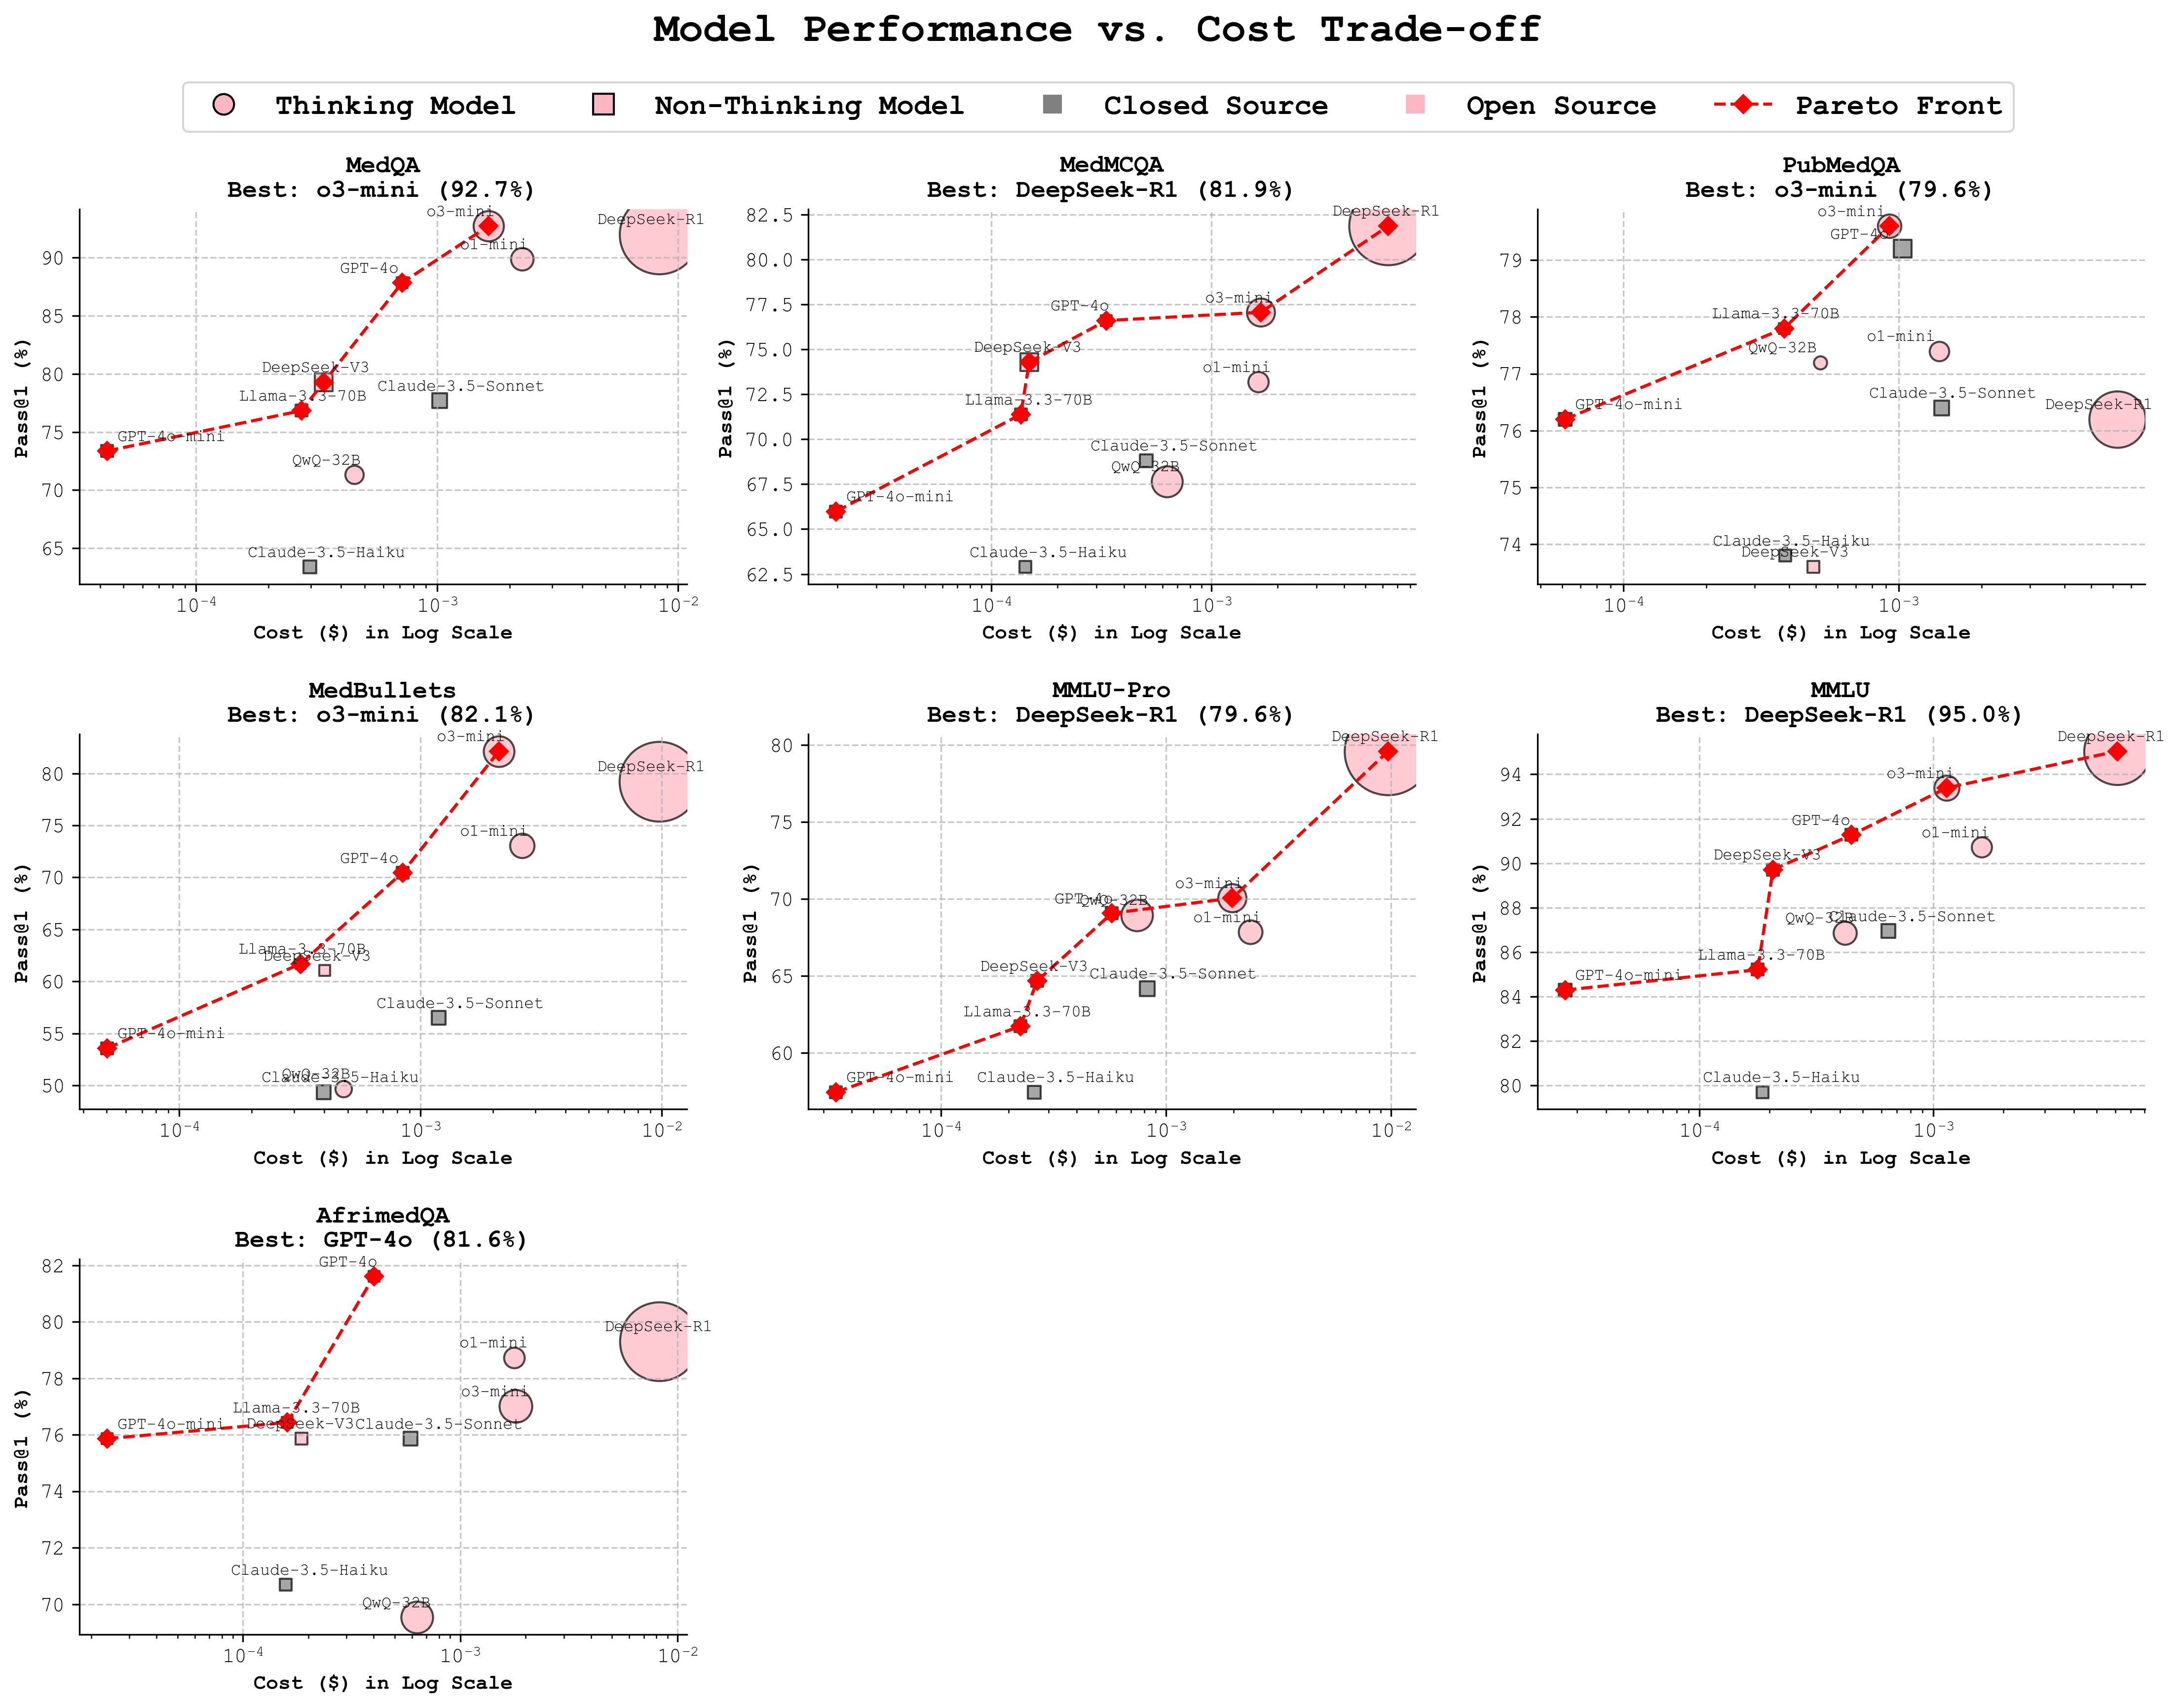

In [4]:
import os
import json
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

# Set professional fonts and colors
plt.rcParams['font.family'] = 'Courier New'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Custom font settings
title_font = {'family': 'Courier New', 'size': 16, 'weight': 'bold'}
legend_font = {'family': 'Courier New', 'size': 8, 'weight': 'bold'} 
number_font = {'family': 'Courier New', 'size': 10}

# Define datasets (in the desired order)
datasets = ['medqa', 'medmcqa', 'pubmedqa', 'medbullets', 'mmlu-pro', 'mmlu', 'afrimedqa']
dataset_map = {
    'medqa': 'MedQA',
    'pubmedqa': 'PubMedQA', 
    'medmcqa': 'MedMCQA',
    'medbullets': 'MedBullets',
    'mmlu': 'MMLU',
    'mmlu-pro': 'MMLU-Pro',
    'afrimedqa': 'AfrimedQA',
    'mmlu-pro': 'MMLU-Pro',
    'afrimedqa': 'AfrimedQA'
}

# Use the existing models list
models = [
    'gpt-4o-mini',
    'gpt-4o',
    'DeepSeek-V3',
    'o1-mini',
    'o3-mini', 
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
model_map = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'o1-mini': 'o1-mini',
    'o3-mini': 'o3-mini',
    'DeepSeek-V3': 'DeepSeek-V3',
    'DeepSeek-R1': 'DeepSeek-R1',
    'QwQ-32B-Preview': 'QwQ-32B',
    'Llama-3.3-70B-Instruct-Turbo': 'Llama-3.3-70B',
    'claude-3-5-sonnet': 'Claude-3.5-Sonnet',
    'claude-3-5-haiku': 'Claude-3.5-Haiku'
}

# Create subplots
ncols = 3
nrows = math.ceil(len(datasets) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), dpi=300)
axes = axes.flatten()

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    dataset_stats = {}

    # For each model, load its full test set performance
    for model in models:
        model_filename = model.replace('/', '_')
        file_path = os.path.join('..', 'output', dataset, f"{model_filename}-{dataset}-test-zero_shot.json")
        if not os.path.exists(file_path):
            print(f"JSON file not found for model '{model}' in dataset '{dataset}': {file_path}")
            continue
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {file_path}: {e}")
                continue

        dedup_data = deduplicate_data(data)
        total_samples = len(dedup_data)
        if total_samples == 0:
            continue

        acc = calculate_accuracy(dedup_data)
        cost_per_sample = calculate_cost_from_token_usage(dedup_data, model)
        avg_time = calculate_time_from_data(dedup_data)
        correct = acc * total_samples

        dataset_stats[model] = {
            'total_correct': correct,
            'total_samples': total_samples,
            'total_cost': cost_per_sample * total_samples,
            'total_time': avg_time * total_samples
        }

    ds_model_names = []
    ds_avg_accuracies = []
    ds_avg_costs = []
    ds_avg_times = []

    for model, stats in dataset_stats.items():
        if stats['total_samples'] > 0:
            overall_acc = stats['total_correct'] / stats['total_samples']
            avg_cost = stats['total_cost'] / stats['total_samples']
            overall_time = stats['total_time'] / stats['total_samples']
            ds_model_names.append(model)
            ds_avg_accuracies.append(overall_acc)
            ds_avg_costs.append(avg_cost)
            ds_avg_times.append(overall_time)

    # Compute Pareto frontier
    ds_points = list(zip(ds_avg_costs, ds_avg_accuracies))
    ds_pareto_indices = []
    for i, (cost, acc) in enumerate(ds_points):
        dominated = False
        for j, (other_cost, other_acc) in enumerate(ds_points):
            if i == j:
                continue
            if (other_cost <= cost and other_acc >= acc) and ((other_cost < cost) or (other_acc > acc)):
                dominated = True
                break
        if not dominated:
            ds_pareto_indices.append(i)

    ds_pareto_points = sorted(
        [(ds_avg_costs[i], ds_avg_accuracies[i], ds_model_names[i]) for i in ds_pareto_indices],
        key=lambda x: x[0]
    )
    ds_pareto_costs = [pt[0] for pt in ds_pareto_points]
    ds_pareto_accs = [pt[1] * 100 for pt in ds_pareto_points]

    # Find best performing model
    best_acc_idx = np.argmax(ds_avg_accuracies)
    best_acc = ds_avg_accuracies[best_acc_idx] * 100
    best_model = ds_model_names[best_acc_idx]

    # Plot with a professional color scheme
    size_scale = 30
    for i, model in enumerate(ds_model_names):
        cost = ds_avg_costs[i]
        acc_percent = ds_avg_accuracies[i] * 100
        time_val = ds_avg_times[i]
        marker_size = time_val * size_scale

        lower_model = model.lower()
        is_thinking = any(kw in lower_model for kw in ['r1', 'qwq', 'o1-mini', 'o3-mini'])
        marker = 'o' if is_thinking else 's'
        is_closed = ('gpt' in lower_model or 'claude' in lower_model)
        color = '#808080' if is_closed else '#FFB6C1'  # Grey vs Pink

        ax.scatter(cost, acc_percent, s=marker_size, marker=marker, color=color,
                   alpha=0.7, edgecolors='#000000')  # Black edge
        ax.annotate(model_map[model], (max(min(ds_avg_costs), cost / 2), acc_percent), 
                    textcoords="offset points", xytext=(5, 5), fontsize=8)

    # Overlay Pareto frontier
    ax.plot(ds_pareto_costs, ds_pareto_accs, color='red', linestyle='--',
            marker='D', markersize=6)

    ax.set_title(f"{dataset_map[dataset]}\nBest: {model_map[best_model]} ({best_acc:.1f}%)", 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel("Cost ($) in Log Scale", fontsize=10, fontweight='bold')
    ax.set_ylabel("Pass@1 (%)", fontsize=10, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Clean styling
    ax.set_facecolor('#FFFFFF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Disable extra subplots
for j in range(len(datasets), len(axes)):
    axes[j].axis('off')

# Create legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Thinking Model',
           markerfacecolor='#FFB6C1', markersize=10, markeredgecolor='#000000'),
    Line2D([0], [0], marker='s', color='w', label='Non-Thinking Model',
           markerfacecolor='#FFB6C1', markersize=10, markeredgecolor='#000000'),
    Line2D([0], [0], marker='s', color='#808080', label='Closed Source',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='#FFB6C1', label='Open Source',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='D', color='red', label='Pareto Front',
           markersize=6, linestyle='--')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.93),
          ncol=5, prop={'size': 14, 'weight': 'bold'})

fig.suptitle("Model Performance vs. Cost Trade-off", 
             weight='bold', fontsize=20, y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()